# Automated Moon crater counting

This notebook provides an overview of automated feature detection technique using a spacial image of the Moon in application to crater counting. The derined crater size distribution can be applied to age estimation of the surface. The code examples are included for practical implementation.

## Table of Contents

1. [Introduction](#1)
2. [Geology of the Moon](#2)
3. [Image processing for automated detection](#3)
4. [Crater size distribution](#4)
5. [Summary](#5)


<a id="1"></a> 
## Introduction

The Moon's surface is heavily cratered, serving as a record of its geological history. By counting the number of craters in a given area and analyzing their size distribution, scientists can estimate the age of that surface. Here, we use a grayscale image of the surface of the Moon to automatically detect location and diameter of the craters. We apply image processing to enhance the image and the circle Hough transform for cracter detection (see previous workshop for explanation of Hough transform).   

<a id="2"></a> 
## Geology of the Moon

**Formation** The Moon is thought to have formed about 4.5 billion years ago, shortly after the Earth, from debris produced by a giant impact between Earth and a Mars-sized body.

**Maria and Highlands** The Moon has flat, dark plains known as "Maria," mainly made up of basalt. The lighter regions are called "Highlands," primarily composed of anorthosite.

**Impact Craters** The Moon's surface is heavily cratered. The longer a surface has been exposed to space, the more craters it will accumulate. Smaller craters form more frequently than larger ones. A very old surface will have had time to accumulate both small and large craters. The distribution of these craters will closely follow the power-law distribution

**Regolith** The Moon's surface is covered by a loose layer of fragmented material called regolith, formed by billions of years of meteoroid impacts.

**Tectonic Activity** The Moon is not tectonically active, meaning it doesn't have processes like earthquakes or volcanism currently shaping its surface.

In [ ]:
import requests


# Download the image
url = 'https://www.solarsystemscope.com/textures/download/8k_moon.jpg'
response = requests.get(url)

# Save the image
with open('moon.jpg', 'wb') as f:
    f.write(response.content)

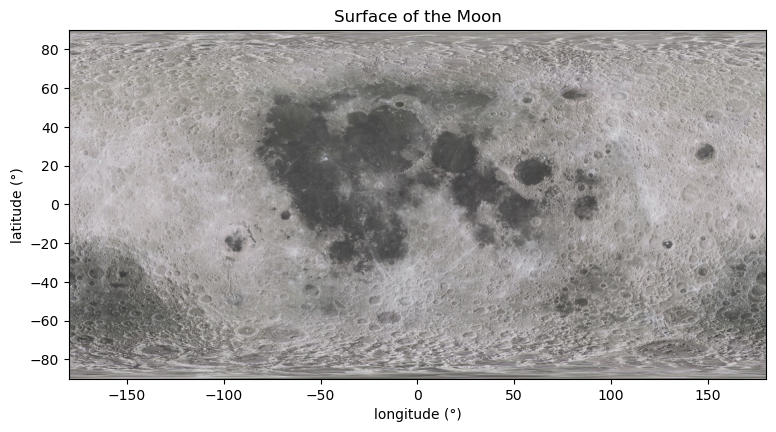

Name            Shape                 Bytes            Type

I1              4096 x 8192 x 3       100663296        uint8
I2              4096 x 8192           268435456        float64

Upper bound on total bytes  =       369098752


In [6]:
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
import numpy as np
# Read the image
I1 = plt.imread('moon.jpg')

#convert to grayscale (intensity map)
I2 = color.rgb2gray(I1)

# Display the image
plt.figure(figsize=(9, 6))
plt.imshow(I1, extent=[-180, 180, -90, 90], cmap='gray')
plt.xlabel('longitude (°)')
plt.ylabel('latitude (°)')
plt.title('Surface of the Moon')
plt.show()

np.who()

<a id="3"></a> 
## Image processing for automated detection

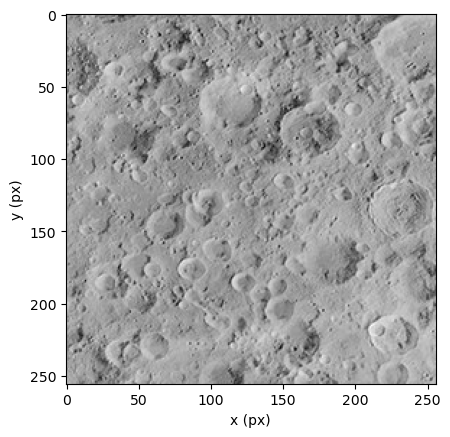

In [7]:
#select a subset of data
I3 = I2[1200:1456,500:756]
plt.imshow(I3, cmap='gray')
plt.xlabel('x (px)')
plt.ylabel('y (px)')
plt.show()

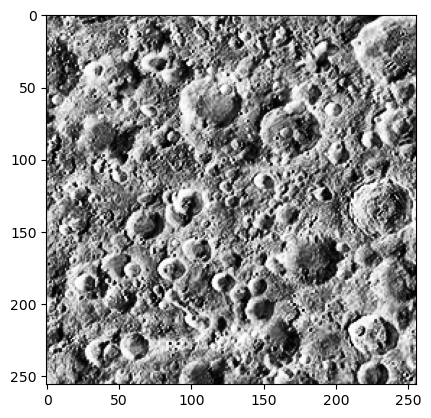

In [8]:
# enhance contrast using adaptive histogram equilization 
# https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
from skimage import exposure
I4 = exposure.equalize_adapthist(I3,clip_limit=0.1,nbins=256)
plt.imshow(I4,cmap='gray')
plt.show()

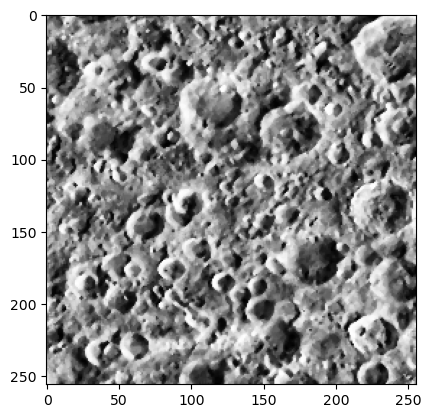

In [9]:
# Apply median filtering 
# averaging insliding 3x3 windows to remove speck noise
from scipy.ndimage import median_filter
I5 = median_filter(I4, size=3)  
plt.imshow(I5,cmap='gray')
plt.show()

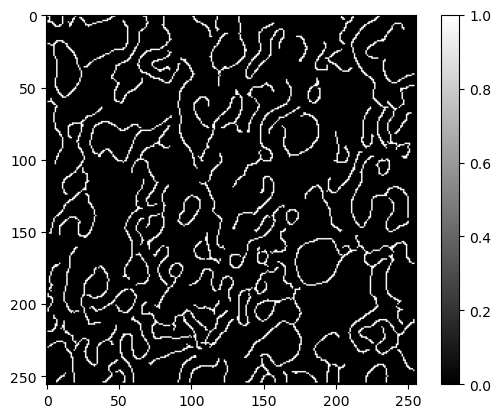

In [10]:
#Find edges in the image

#We are looking for local maxima of the gradient of the image. 
#The edge function calculates the gradient using the derivative of a Gaussian filter. 
#This method uses two thresholds to detect strong and weak edges, including weak edges in the output
#if they are connected to strong edges. By using two thresholds, the Canny method is less likely 
#than the other methods to be fooled by noise, and more likely to detect true weak edges.
from skimage.feature import canny
threshold2 = 0.4
I6 = canny(I5,3,low_threshold=threshold2*0.4, high_threshold=threshold2) #Standard deviation of the Gaussian filter sigma=3
plt.imshow(I6, cmap='gray')
plt.colorbar()
plt.show()
#result is a binary image with 1 (true) for edges and 0 (false) for background

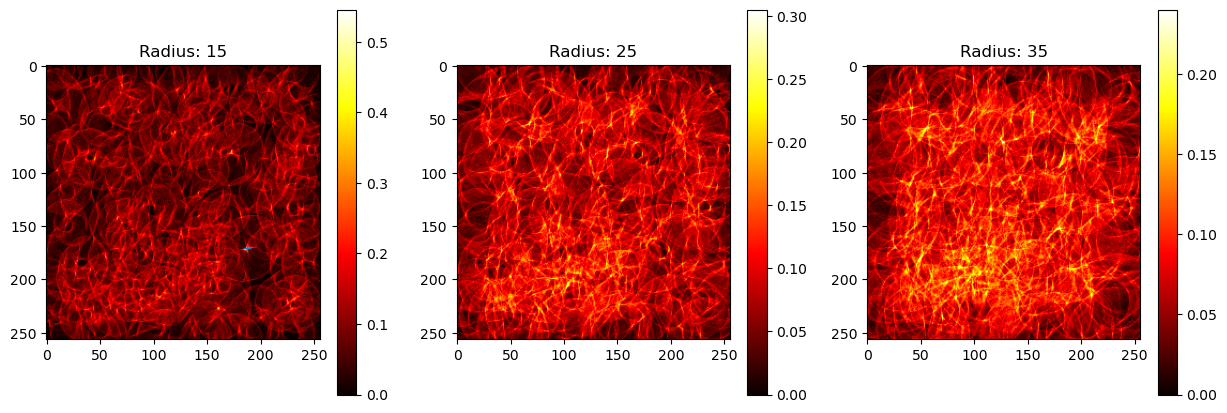

In [12]:
from skimage import transform
from skimage import draw
hough_radii = np.arange(5,40)
hough_res = transform.hough_circle(I6,hough_radii)
# Slices through the Hough space
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
i1=10
i2=20
i3=30
H,cx,cy,radii = transform.hough_circle_peaks(hough_res,hough_radii,min_xdistance=5,min_ydistance=5,total_num_peaks=50)
cax1=axes[0].imshow(hough_res[i1,:,:], cmap='hot')
cax2=axes[1].imshow(hough_res[i2,:,:], cmap='hot')
cax3=axes[2].imshow(hough_res[i3,:,:], cmap='hot')
axes[0].plot(cx[radii==15],cy[radii==15],'+')
axes[1].plot(cx[radii==25],cy[radii==25],'+')
axes[2].plot(cx[radii==35],cy[radii==35],'+')
axes[0].set_title('Radius: '+str(hough_radii[i1]))
axes[1].set_title('Radius: '+str(hough_radii[i2]))
axes[2].set_title('Radius: '+str(hough_radii[i3]))

fig.colorbar(cax1, ax=axes[0])
fig.colorbar(cax2, ax=axes[1])
fig.colorbar(cax3, ax=axes[2])
plt.show()

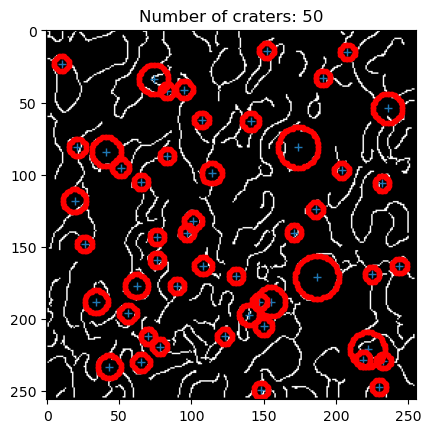

In [225]:
H,cx,cy,radii = transform.hough_circle_peaks(hough_res,hough_radii,min_xdistance=5,min_ydistance=5,total_num_peaks=50)
nstr = 'Number of craters: '+str(len(radii))
plt.imshow(I6, cmap='gray')
plt.plot(cx,cy,'+')
plt.title(nstr)
for i in range(0,len(H)):
    circy,circx = draw.circle_perimeter(cy[i],cx[i],radii[i])
    plt.plot(circx,circy,'.r',)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Number of craters: 50')

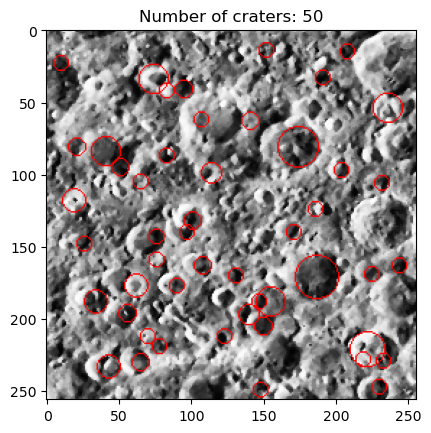

In [226]:
from skimage import draw
m,n = np.shape(I6)
plt.figure()
#plt.axis('off')
I7 = color.gray2rgb(I5)
for i in range(0,len(H)):
    circy,circx = draw.circle_perimeter(cy[i],cx[i],radii[i])
    circyn = np.delete(circy,(circy>=m)|(circx>=n))
    circxn = np.delete(circx,(circy>=m)|(circx>=n))
    I7[circyn,circxn] = (255,0,0)
plt.imshow(I7)
#plt.imshow(I5,cmap='gray')
plt.title(nstr)


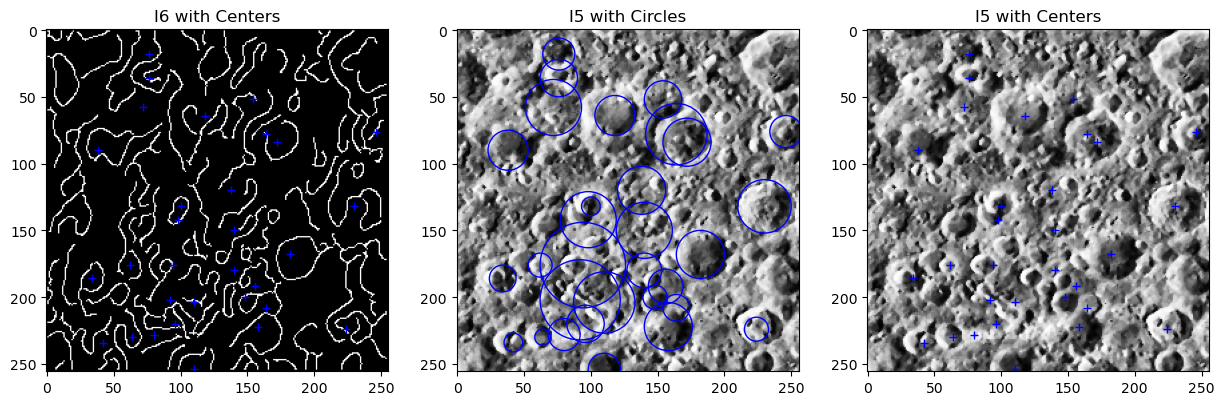

In [224]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Detect circles using HoughCircles
circles = cv2.HoughCircles(I6.astype(np.uint8), cv2.HOUGH_GRADIENT, 1, minDist=10, param1=3, param2=20,\
                           minRadius=5, maxRadius=35)

#print(circles)
#np.who()
# Draw the detected circles
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot original image with center points
axes[0].imshow(I6, cmap='gray')
axes[0].set_title("I6 with Centers")
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for circle in circles:
        axes[0].plot(circle[0], circle[1], '+b')
        
# Plot filtered image with circles
axes[1].imshow(I5, cmap='gray')
axes[1].set_title("I5 with Circles")
if circles is not None:
    for circle in circles:
        axes[1].add_patch(plt.Circle((circle[0], circle[1]), circle[2], color='b', fill=False))

# Plot filtered image with center points
axes[2].imshow(I5, cmap='gray')
axes[2].set_title("I5 with Centers")
if circles is not None:
    for circle in circles:
        axes[2].plot(circle[0], circle[1], '+b')

plt.show()


In [130]:
I6.astype(np.uint8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<a id="4"></a> 
## Crater Size Distribution

The basic idea is that there are many more small craters than large ones. Mathematically, this can be expressed as:

\begin{equation}
N(r) \propto r^{-k}
\end{equation}

where $N(r)$ is the number of craters with a radius larger than $r$ and $k$ is the power-law exponent, usually around 2-3 for lunar craters.


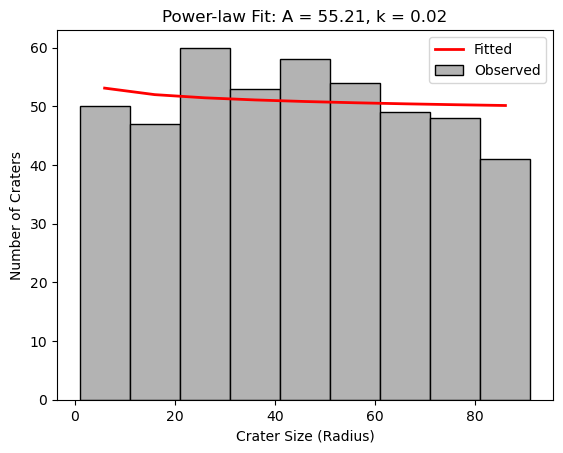

In [221]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Simulated data for demonstration (replace with your observed crater sizes)
crater_sizes = np.random.randint(1, 100, 500)

# Create a histogram with specified bin edges
bin_edges = np.arange(1, 101, 10)
N, edges = np.histogram(crater_sizes, bins=bin_edges)

# Calculate bin centers
bin_centers = (edges[:-1] + edges[1:]) / 2

# Nonlinear curve fitting
def power_law(r, A, k):
    return A * r ** (-k)

# Initial guesses for A and k
initial_guesses = [1000, 2]

# Fit the curve
params, _ = curve_fit(power_law, bin_centers, N)

# Generate fitted data
A_fit, k_fit = params
fitted_N = power_law(bin_centers, A_fit, k_fit)

# Plot results
plt.figure()
plt.bar(bin_centers, N, width=np.diff(bin_edges), color=[0.7, 0.7, 0.7], edgecolor='k', label='Observed')
plt.plot(bin_centers, fitted_N, 'r', linewidth=2, label='Fitted')
plt.xlabel('Crater Size (Radius)')
plt.ylabel('Number of Craters')
plt.legend()
plt.title(f'Power-law Fit: A = {A_fit:.2f}, k = {k_fit:.2f}')
plt.show()

<a id="5"></a> 
## Summary